Data: period=7d, interval=1m, bars=388, Q=100,000 shares, max_part=15%
Session VWAP: 250.4191 | Ref p0: 248.0200

VWAP : {'filled': 100000, 'avg_px': 251.5124, 'cost_per_share': 3.4924, 'IS': 0.014081, 'slip_vs_sessionVWAP': np.float64(0.004366), 'bars_used_%': np.float64(100.0)}
POV  : {'filled': 4012742, 'avg_px': 259.2869, 'cost_per_share': 11.2669, 'IS': 0.045427, 'slip_vs_sessionVWAP': np.float64(0.035412), 'bars_used_%': np.float64(100.0)}
Greedy: {'filled': 99999, 'avg_px': 252.4645, 'cost_per_share': 4.4445, 'IS': 0.01792, 'slip_vs_sessionVWAP': np.float64(0.008168), 'bars_used_%': np.float64(100.0)}

Saved fills to C:\Users\adity\Downloads\Learn_DSA_Quant\Level-20


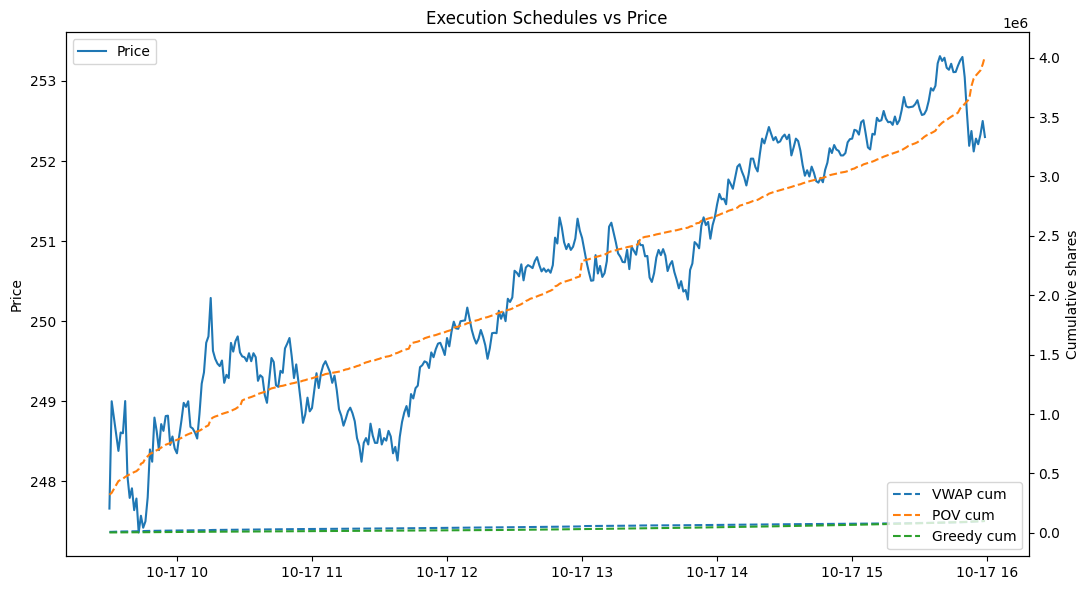

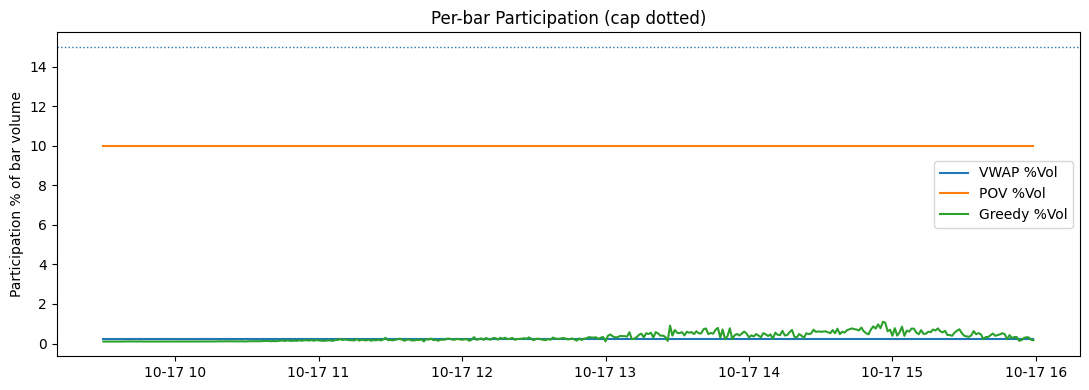

In [2]:
# Step 20 — Greedy + Order Execution Cost Minimization (hardened)
# - No FutureWarnings (scalar extraction fixed)
# - No ambiguous Series truth-values (use NumPy scalars)
# - Robust to yfinance column quirks

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------ Utilities ------------------
def to_1d_float(a) -> np.ndarray:
    """Return a 1-D float NumPy array from Series/DataFrame/array-like."""
    return np.asarray(a, dtype=float).reshape(-1)

def last_scalar(a) -> float:
    """Return the last element as a Python float from Series/DataFrame/array-like."""
    arr = to_1d_float(a)
    if arr.size == 0:
        return float("nan")
    return float(arr[-1])

def first_scalar(a) -> float:
    """Return the first element as a Python float from Series/DataFrame/array-like."""
    arr = to_1d_float(a)
    if arr.size == 0:
        return float("nan")
    return float(arr[0])

# ------------------ Data: 1m bars (fallbacks + timezone) ------------------
def load_intraday(ticker="AAPL"):
    for period, interval in [("7d","1m"), ("30d","5m"), ("60d","15m")]:
        df = yf.download(ticker, period=period, interval=interval, auto_adjust=True, progress=False)
        if not df.empty:
            # Keep only needed columns; resolve possible duplicate column names by selecting the first match.
            cols = ["Open","High","Low","Close","Volume"]
            keep = [c for c in cols if c in df.columns]
            df = df.loc[:, keep].dropna()
            df.index = pd.to_datetime(df.index)
            # Normalize to America/New_York tz
            if df.index.tz is None:
                df.index = df.index.tz_localize("UTC").tz_convert("America/New_York")
            else:
                df.index = df.index.tz_convert("America/New_York")
            return df, period, interval
    raise SystemExit("No intraday data available (or network issue).")

df, period_used, interval_used = load_intraday("AAPL")

# Pick the last full trading day window 09:30–16:00 ET
tz = df.index.tz
last_day = df.index[-1].astimezone(tz).date()
start = pd.Timestamp.combine(last_day, pd.Timestamp("09:30").time()).tz_localize(tz)
end   = pd.Timestamp.combine(last_day, pd.Timestamp("16:00").time()).tz_localize(tz)
day = df.loc[(df.index >= start) & (df.index <= end)].copy()
if len(day) < 200:
    raise SystemExit("Not enough bars in last session window.")

# ------------------ Parameters ------------------
Q = 100_000              # target shares to BUY
max_part = 0.15          # hard cap per-bar participation (<= 15% of bar volume)
p0 = first_scalar(day["Open"])   # reference price for IS (no FutureWarning)

# Approximate ADV from the most recent daily volume in df
vol_daily = df["Volume"].resample("1D").sum().dropna()
ADV = last_scalar(vol_daily)

# Impact model params (tweak to taste)
eta   = 0.10   # temporary impact coefficient
beta  = 0.60   # concavity for temp impact
gamma = 0.05   # permanent impact coefficient

# ------------------ Helpers ------------------
def temp_impact(p, x, V, eta=eta, beta=beta):
    """Temporary impact (per-share) in $: eta * (x/V)**beta * p . Safe for V=0."""
    if V <= 0 or x <= 0:
        return 0.0
    return eta * (x / V)**beta * p

def perm_impact(p, cum_x, ADV=ADV, gamma=gamma):
    """Permanent drift from cumulative executed (per-share) in $: gamma * p * sqrt(cum_x / ADV)."""
    if ADV <= 0 or cum_x <= 0:
        return 0.0
    return gamma * p * np.sqrt(cum_x / ADV)

def simulate_schedule(bars, x_schedule):
    """
    bars: DataFrame with Close, Volume
    x_schedule: array of shares to buy each bar (len == len(bars))
    Returns fills DataFrame with realized price, cost, cum, etc.
    """
    close = to_1d_float(bars["Close"])
    vol   = to_1d_float(bars["Volume"])
    x     = np.clip(to_1d_float(x_schedule), 0, None)

    fills = []
    cum = 0.0
    cost = 0.0
    for i in range(len(bars)):
        xi = x[i]
        if xi <= 0:
            fills.append((bars.index[i], 0.0, 0.0, 0.0, cum, cost)); continue
        p = close[i]
        V = max(1.0, vol[i])
        # impact components
        ti = temp_impact(p, xi, V)
        pi = perm_impact(p, cum)  # drift up as we accumulate (buy side)
        exec_price = p + ti + pi
        fill_cost = xi * exec_price
        cum += xi
        cost += fill_cost
        fills.append((bars.index[i], xi, exec_price, fill_cost, cum, cost))

    out = pd.DataFrame(fills, columns=["ts","qty","px","notional","cum_qty","cum_cost"]).set_index("ts")
    return out

def summarize(fills, p_ref=p0, session_vwap=None):
    """
    Return dict: total, avg_px, cost_per_share, IS, slippage_vs_sessionVWAP, bars_used_%.
    """
    total = float(fills["cum_qty"].iloc[-1])
    notional = float(fills["cum_cost"].iloc[-1])
    avg_px = notional / max(1.0, total)
    is_ = (notional - total * p_ref) / max(1.0, total * p_ref)
    slip_vwap = np.nan
    if session_vwap is not None and session_vwap > 0:
        slip_vwap = (avg_px - session_vwap) / session_vwap
    return {
        "filled": int(total),
        "avg_px": round(avg_px, 4),
        "cost_per_share": round(avg_px - p_ref, 4),
        "IS": round(is_, 6),
        "slip_vs_sessionVWAP": (None if np.isnan(slip_vwap) else round(slip_vwap, 6)),
        "bars_used_%": round(100 * (to_1d_float(fills["qty"]) > 0).mean(), 2),
    }

# Session VWAP for slippage benchmark — compute with NumPy (no ambiguity)
session_vwap = (
    (to_1d_float(day["Close"]) * to_1d_float(day["Volume"])).sum()
    / max(1.0, to_1d_float(day["Volume"]).sum())
)

# ------------------ 1) VWAP schedule ------------------
vol = to_1d_float(day["Volume"])
vol_sum = vol.sum()
vol_share = vol / (vol_sum if vol_sum > 0 else 1.0)
x_vwap = vol_share * Q

# Enforce per-bar cap
cap = max_part * vol
x_vwap = np.minimum(x_vwap, cap)

# If we underfill due to caps, smear the remainder forward greedily within caps
def smear_remainder(x, cap, Q_target):
    x = x.copy()
    rem = Q_target - x.sum()
    if rem <= 0: return x
    for i in range(len(x)):
        add = min(cap[i] - x[i], rem)
        if add > 0:
            x[i] += add
            rem -= add
            if rem <= 0: break
    return x

x_vwap = smear_remainder(x_vwap, cap, Q)
fills_vwap = simulate_schedule(day, x_vwap)
sum_vwap = summarize(fills_vwap, p_ref=p0, session_vwap=session_vwap)

# ------------------ 2) POV schedule (k% of market volume) ------------------
k = 0.10  # 10% participation
x_pov = np.minimum(k * vol, cap)
x_pov = smear_remainder(x_pov, cap, Q)
fills_pov = simulate_schedule(day, x_pov)
sum_pov = summarize(fills_pov, p_ref=p0, session_vwap=session_vwap)

# ------------------ 3) Greedy schedule ------------------
# Intuition: weight bars by (liquidity * cheapness * urgency)
price = to_1d_float(day["Close"])
ema_fast = pd.Series(price, index=day.index).ewm(span=20, adjust=False).mean().to_numpy()
cheap = np.maximum(0.0, (ema_fast - price) / np.maximum(1e-9, ema_fast))   # >0 when price < EMA (good for buy)
liq = vol / np.maximum(1.0, vol.max())                                     # 0..1
tgrid = np.linspace(0.0, 1.0, len(day))                                    # 0 at start, 1 at end
urgency = tgrid**2                                                          # ramps late in day

score = 0.60*cheap + 0.35*liq + 0.05*urgency
score = np.maximum(score, 0)
if score.sum() == 0:
    score[:] = 1.0

# Initial proportional allocation by score, capped by max_part*Vol
x_greedy = (score / score.sum()) * Q
x_greedy = np.minimum(x_greedy, cap)

# Iterate a couple of passes: push leftover to next highest-score bars within caps
def redistribute(x, scores, cap, Q_target, passes=3):
    x = x.copy()
    rem = Q_target - x.sum()
    if rem <= 0: return x
    order = np.argsort(-scores)  # descending score
    for _ in range(passes):
        if rem <= 0: break
        for i in order:
            if rem <= 0: break
            add = min(cap[i] - x[i], rem)
            if add > 0:
                x[i] += add; rem -= add
    return x

x_greedy = redistribute(x_greedy, score, cap, Q, passes=3)
fills_greedy = simulate_schedule(day, x_greedy)
sum_greedy = summarize(fills_greedy, p_ref=p0, session_vwap=session_vwap)

# ------------------ Results ------------------
print(f"Data: period={period_used}, interval={interval_used}, bars={len(day)}, Q={Q:,} shares, max_part={int(max_part*100)}%")
print(f"Session VWAP: {session_vwap:.4f} | Ref p0: {p0:.4f}")
print("\nVWAP :", sum_vwap)
print("POV  :", sum_pov)
print("Greedy:", sum_greedy)

# ------------------ Save fills ------------------
out_dir = Path(r"C:\Users\adity\Downloads\Learn_DSA_Quant\Level-20")
out_dir.mkdir(parents=True, exist_ok=True)
fills_vwap.assign(strategy="VWAP").to_csv(out_dir / "fills_vwap.csv")
fills_pov.assign(strategy="POV").to_csv(out_dir / "fills_pov.csv")
fills_greedy.assign(strategy="Greedy").to_csv(out_dir / "fills_greedy.csv")
print(f"\nSaved fills to {out_dir}")

# ------------------ Plots ------------------
fig, ax = plt.subplots(figsize=(11,6))
ax.plot(day.index, price, label="Price")
ax.set_ylabel("Price"); ax.set_title("Execution Schedules vs Price")
ax2 = ax.twinx()
ax2.plot(day.index, to_1d_float(fills_vwap["cum_qty"]),  linestyle="--", label="VWAP cum")
ax2.plot(day.index, to_1d_float(fills_pov["cum_qty"]),   linestyle="--", label="POV cum")
ax2.plot(day.index, to_1d_float(fills_greedy["cum_qty"]),linestyle="--", label="Greedy cum")
ax2.set_ylabel("Cumulative shares")
ax.legend(loc="upper left")
ax2.legend(loc="lower right")
plt.tight_layout(); plt.show()

# Per-bar participation (sanity)
fig2, ax3 = plt.subplots(figsize=(11,4))
den = np.maximum(1.0, vol)
part_vwap = to_1d_float(fills_vwap["qty"])   / den * 100
part_pov  = to_1d_float(fills_pov["qty"])    / den * 100
part_gre  = to_1d_float(fills_greedy["qty"]) / den * 100
ax3.plot(day.index, part_vwap, label="VWAP %Vol")
ax3.plot(day.index, part_pov,  label="POV %Vol")
ax3.plot(day.index, part_gre,  label="Greedy %Vol")
ax3.axhline(max_part*100, linestyle=":", linewidth=1)
ax3.set_ylabel("Participation % of bar volume"); ax3.set_title("Per-bar Participation (cap dotted)")
ax3.legend(); plt.tight_layout(); plt.show()
